# Complete Simulation Chain for Visibility Calculation

## Read in Config

In [4]:
import vipy.simulation.utils as ut
import vipy.layouts.layouts as layouts
import astropy.constants as const
from astropy import units as un

In [5]:
rc = ut.read_config('/net/nfshome/home/sfroese/vipy/config/default.toml')
array_layout = layouts.get_array_layout('eht')

src_crd = rc['src_coord']
wave1 = const.c/((float(rc['channel'].split(':')[0])-float(rc['channel'].split(':')[1]))*10**6/un.second)/un.meter
wave2 = const.c/((float(rc['channel'].split(':')[0])+float(rc['channel'].split(':')[1]))*10**6/un.second)/un.meter

## Generate (l,m)-plane / FOV

In [6]:
import vipy.simulation.scan as scan

In [7]:
grid = scan.create_bgrid(rc['fov_size'], 256, src_crd)
lm = scan.lm(grid, src_crd)

## Calculate Start and Stop times for every measurement

In [8]:
time = ut.calc_time_steps(rc)
time.shape

(2161,)

## Calculate Baselines for one measurement

In [9]:
baselines = scan.get_baselines(src_crd, time[:31], array_layout)

## Calculate Mueller/Jones matrices

In [10]:
import numpy as np

In [11]:
JJ_f1 = scan.getJones(lm, baselines, wave1, time, src_crd, array_layout)
JJ_f2 = scan.getJones(lm, baselines, wave2, time, src_crd, array_layout)

/scratch/sfroese/envs/radionets/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


## Open Source Image and compute Stokes vector

In [12]:
from astropy.io import fits
import matplotlib.pyplot as plt

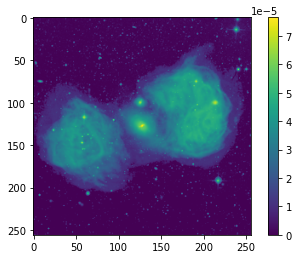

In [13]:
hdul = fits.open('/net/big-tank/POOL/users/sfroese/radionets/vlbi/training/staticCelestial/targetImgs/celestial-03-05.fits')
img = hdul[0].data

I = np.zeros((img.shape[0],img.shape[1],4))
I[...,0] = img
I[...,1] = img*np.sqrt(0.5)
I[...,2] = img*np.sqrt(0.5)
plt.imshow(I[...,1]+I[...,2])
plt.colorbar()

## Integration

In [14]:
delta_t = rc['corr_int_time']
delta_f = float(rc['channel'].split(':')[1])*10**6
delta_l = lm[255,0,0]-lm[0,0,0]
delta_m = lm[0,255,0]-lm[0,0,0]

integral = scan.integrate(JJ_f1, JJ_f2, I, 28, delta_t, delta_f, delta_l, delta_m)
integral

<Quantity [[-0.00095321-0.0014907j ,  0.001178  +0.00184224j,
            -0.00287939-0.00450299j,  0.00355843+0.00556492j],
           [ 0.00144071+0.00625134j,  0.00289853+0.01257695j,
             0.00059676+0.00258939j,  0.00120061+0.00520954j],
           [ 0.01980803+0.00432631j,  0.00217797+0.00047569j,
            -0.0184122 -0.00402144j, -0.00202449-0.00044217j],
           ...,
           [-0.00971651+0.00453963j, -0.00249249+0.00116451j,
            -0.00402471+0.00188037j, -0.00103242+0.00048236j],
           [ 0.01156318-0.01571209j, -0.01429009+0.01941744j,
             0.0029662 -0.00403048j, -0.00366571+0.00498098j],
           [-0.0025003 +0.00125775j, -0.00755274+0.00379931j,
            -0.00064138+0.00032264j, -0.00193743+0.0009746j ]]>

In [15]:
integral.shape

(840, 4)